In [1]:
!pip install bellmanford

  Created wheel for bellmanford: filename=bellmanford-0.2.1-cp37-none-any.whl size=5035 sha256=cd9e68697b11a3328786724fa284aed165ac835eba60e24ef062571b62acf0a9
  Stored in directory: /root/.cache/pip/wheels/20/61/3e/dd8db6229092c23e25793b7f2da494b31d870b73d44b4440d6
Successfully built bellmanford


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold, datasets
import networkx as nx

import bellmanford as bf

from sklearn.datasets import load_digits  #mnist
from scipy.optimize import minimize

# Константинов Даниил Николаевич
#### М05-015а
# Алгоритм ISOMAP

In [ ]:
#X, y = datasets.make_circles(n_samples=50, factor=.5, noise=.05)

In [28]:
# евклидово расстояние
def distance(x, y):
  return np.sqrt(sum((x - y)**2))

# матрица расстояний
def matrix_distances(X):
  m_dist = np.zeros((X.shape[0],X.shape[0]))
  for i in range(X.shape[0] - 1):
    m_dist[i][i+1:] = [distance(X[i], X[j]) for j in range(i + 1, X.shape[0])]
  return m_dist + m_dist.T

# k - число соседей
# матрица расстояний до соседей и 
def matrix_neighbours(dist, k):
  m_neighb_dist = np.zeros((dist.shape[0], k))  # расстояния до соседей
  m_neighb_numbers = np.zeros((dist.shape[0], k))  # номера соседей
  for i in range(X.shape[0]):
    m_neighb_dist[i] = np.sort(dist[i])[1: k + 1]
    m_neighb_numbers[i] = np.argsort(dist[i])[1: k + 1]
  return m_neighb_dist, m_neighb_numbers

# вычисление матрицу смежности и создание матрицу     лишняя
def matrix_adjacency(m_neighb_dist, m_neighb_numbers):
  n1 = m_neighb_dist.shape[0]
  n2 = m_neighb_dist.shape[1]
  mat = np.zeros((n1, n1)) # матрица смежности
  for i in range(n1):
    for j in range(n2):
      mat[i, int(m_neighb_numbers[i, j])] = m_neighb_dist[i, j]
  return mat

# матрица кратчайших расстояний
def matrix_shortest_pathes(m_neighb_numbers, m_neighb_dist):
  # создаем граф
  G = nx.Graph()
  G.add_nodes_from(range(X.shape[0]))
  n1 = m_neighb_dist.shape[0]
  n2 = m_neighb_dist.shape[1]
  
  for i in range(n1):
    for j in range(n2):
      G.add_edge(i, int(m_neighb_numbers[i, j]), weight = m_neighb_dist[i, j])
  # вычисляем саму матрицу
  m_short_d = np.zeros((n1, n1))
  for i in range(n1 - 1):
    m_short_d[i, i + 1:] = [bf.bellman_ford(G, source=i, target=j, weight="weight")[0] for j in range(i + 1, n1)]
  
  return m_short_d + m_short_d.T
  
# матрица кратчайших расстояний, эта быстрее предыдущей
def matrix_shortest_pathes2(m_neighb_numbers, m_neighb_dist):
  # создаем граф
  G = nx.Graph()
  G.add_nodes_from(range(X.shape[0]))
  n1 = m_neighb_dist.shape[0]
  n2 = m_neighb_dist.shape[1]
  
  for i in range(n1):
    for j in range(n2):
      G.add_edge(i, int(m_neighb_numbers[i, j]), weight = m_neighb_dist[i, j])
  
  aa = dict(nx.floyd_warshall(G))
  # вычисляем саму матрицу
  m_short_d = np.zeros((n1, n1))
  for i in range(n1):
    for j in range(i + 1, n1):
      m_short_d[i, j] = aa[i][j]

  return m_short_d + m_short_d.T

In [131]:
def f(X, *args):
  d = args[0]
  s = 0.0
  for i in range(d.shape[0] - 1):
    for j in range(i + 1, d.shape[0]):
        x1 = np.array([X[2*i], X[2*i + 1]])
        x2 = np.array([X[2*j], X[2*j + 1]])
        s += (d[i, j] - distance(x1, x2))**2
    return np.sqrt(s)

def main1(X, k_neighb = 8):
  a = matrix_distances(X)
  neighb_dist, neighb_numbers = matrix_neighbours(a, k_neighb)
  d = matrix_shortest_pathes2(neighb_numbers, neighb_dist) # получили матрицу с кратчайшими путями
  INF = 1e5
  m = max([i for i in d.flatten() if i < INF])
  m += m / 2.0
  for i in range(d.shape[0]):
    for j in range(d.shape[0]):
      if d[i, j] > INF:
        d[i, j] = m + np.random.choice([m / 2, m / 4, m / 8])
  return d

def approx_x0(d):
  D = d**2
  n = d.shape[0]
  C = np.eye(n) - 1.0 / n * np.ones((n, n))
  B = -0.5 * C @ D @ C
  lambdas, vectors = np.linalg.eigh(B)
  l_sort = np.argsort(lambdas)[::-1]
  l_m = np.eye(2)
  l_m[0, 0] = np.sqrt(lambdas[l_sort[0]])
  l_m[1, 1] = np.sqrt(lambdas[l_sort[1]])
  e_m = np.column_stack([vectors[l_sort[0]], vectors[l_sort[1]]])
  yy = e_m @ l_m
  return yy.flatten()

def main2(d, f):
 # x0 = np.array([np.random.normal(0, 4.0) for _ in range(2 * d.shape[0])]) # начальное приближение
  x0 = approx_x0(d)
  options={ 'maxiter': 70}
  f_min = minimize(f, x0, args=d, tol=1e-1, options=options)  # минимизация функции
  return f_min

Пример с много-d данными

In [138]:
X, labels = load_digits(n_class=2, return_X_y=True) #load data
X, labels = X[:100], labels[:100]

In [139]:
%%time

d = main1(X, k_neighb = 5)
res = main2(d, f)

CPU times: user 27.3 s, sys: 7.59 s, total: 34.9 s
Wall time: 26.5 s


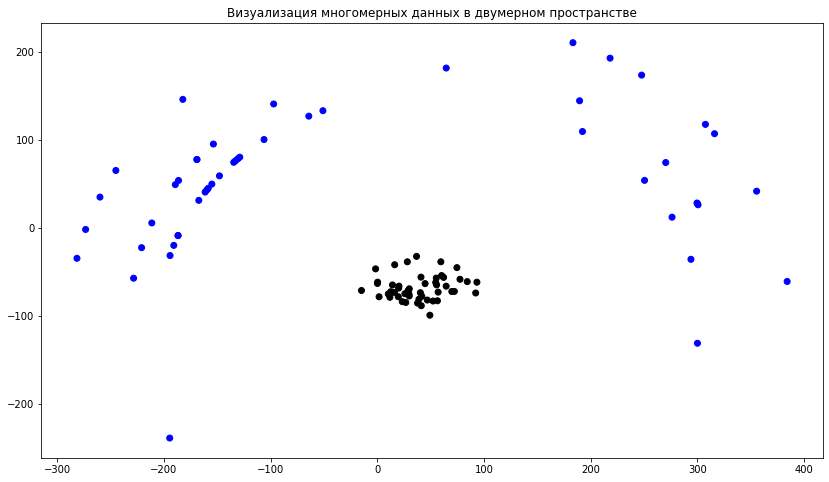

In [140]:
X_new = np.reshape(res.x, (-1, 2))
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
col = [colors[labels[i]] for i in range(len(X_new[:, 0]))]  # цвета для меток
ax.scatter(X_new[:, 0], X_new[:, 1], c=col)
plt.title("Визуализация многомерных данных в двумерном пространстве")
plt.show()

### Пример с 2d данными

In [151]:
X, labels = datasets.make_circles(n_samples=100, factor=.3, noise=.03)

In [152]:
d = main1(X, k_neighb = 4)
res = main2(d, f)

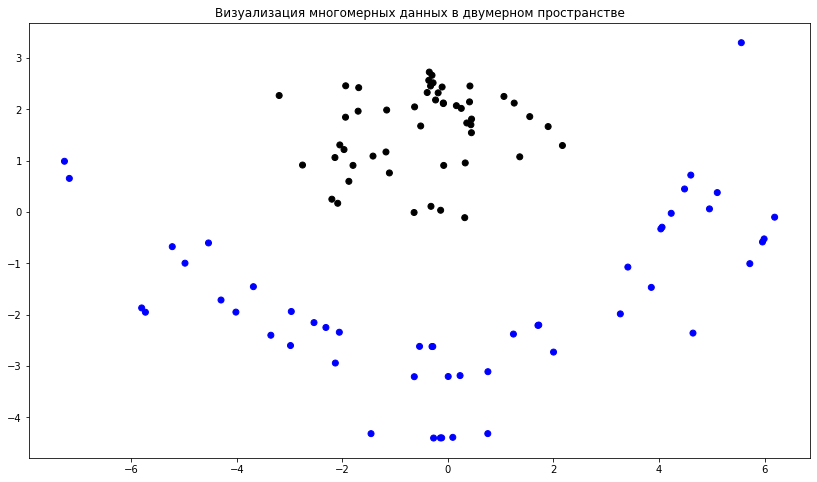

In [153]:
X_new = np.reshape(res.x, (-1, 2))
x = X_new[:, 0]
y = X_new[:, 1]
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
col = [colors[labels[i]] for i in range(len(x))]  # цвета для меток
ax.scatter(x, y, c=col)
plt.title("Визуализация многомерных данных в двумерном пространстве")
plt.show()